<a href="https://colab.research.google.com/github/QuocHuy-1602/ecg-anomaly-detection/blob/master/ecg_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="section-one"></a>
# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch

* [Time Series Anomaly Detection using LSTM Autoencoders with PyTorch](#section-one)
* [Data](#section-two)
    - [Data Preprocessing](#section-three)
    - [Data Exploration](#section-four)
* [Building an LSTM Autoencoder](#section-five)
    - [Training](#section-six)
    - [Saving the model](#section-seven)
* [Choosing a Threshold](#section-eight)
* [Evaluation](#section-nine)
    - [Normal hearbeat Predictions](#section-ten)
    - [Anomaly predictions](#section-eleven)
* [Looking at Examples](#section-twelve)

In [ ]:
!nvidia-smi

Sat May 18 12:24:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8               4W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import arff
from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style= 'whitegrid', palette= 'muted', font_scale= 1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

<a id="section-two"></a>
## Data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # if gpu is available use gpu

In [ ]:
# Load ARFF file
with open('D:\Github\THT_Delta_Cognition\Data\ECG5000_TRAIN.arff', 'r') as f:
    train_dict = arff.load(f)

# Convert to pandas DataFrame
train = pd.DataFrame(train_dict['data'], columns=[i[0] for i in train_dict['attributes']])

# Load ARFF file
with open('D:\Github\THT_Delta_Cognition\Data\ECG5000_TEST.arff', 'r') as f:
    test_dict = arff.load(f)

# Convert to pandas DataFrame
test = pd.DataFrame(test_dict['data'], columns=[i[0] for i in test_dict['attributes']])

In [ ]:
train.head()

att1      att2      att3      att4      att5      att6      att7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

     att136    att137    att138    att139    att140  target  
0  0.257740  0.228077  0.123431  0.925286  0.193137       1  
1  0.555784  0.476333  0.773820  1.119621 -1.436250       1  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797       1  
3  0.952074  0.990133  1.086798  1.403011 -0.383564       1  
4  1.277392  0.960304  0.971020  1.614392  1.421456       1  

[5 rows x 141 columns]

In [ ]:
test.head()

att1      att2      att3      att4      att5      att6      att7  \
0  3.690844  0.711414 -2.114091 -4.141007 -4.574472 -3.431909 -1.950791   
1 -1.348132 -3.996038 -4.226750 -4.251187 -3.477953 -2.228422 -1.808488   
2  1.024295 -0.590314 -1.916949 -2.806989 -3.527905 -3.638675 -2.779767   
3  0.545657 -1.014383 -2.316698 -3.634040 -4.196857 -3.758093 -3.194444   
4  0.661133 -1.552471 -3.124641 -4.313351 -4.017042 -3.005993 -1.832411   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.107067 -0.632322  0.334577  ...  0.022847  0.188937  0.480932  0.629250   
1 -1.534242 -0.779861 -0.397999  ...  1.570938  1.591394  1.549193  1.193077   
2 -2.019031 -1.980754 -1.440680  ...  0.443502  0.827582  1.237007  1.235121   
3 -2.221764 -1.588554 -1.202146  ...  0.777530  1.119240  0.902984  0.554098   
4 -1.503886 -1.071705 -0.521316  ...  1.280823  1.494315  1.618764  1.447449   

     att136    att137    att138    att139    att140  target  
0  0.577291  0.665527  1.035997  1.492287 -1.905073       1  
1  0.515134  0.126274  0.267532  1.071148 -1.164009       1  
2  1.738103  1.800767  1.816301  1.473963  1.389767       1  
3  0.497053  0.418116  0.703108  1.064602 -0.044853       1  
4  1.238577  1.749692  1.986803  1.422756 -0.357784       1  

[5 rows x 141 columns]

In [ ]:
df = pd.concat([train, test])
df = df.sample(frac=1.0)  # shuffling dataframe
df.shape

(5000, 141)

In [ ]:
CLASS_NORMAL = 1

class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

## Data Preprocessing

In [ ]:
#changing name of the target column

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns =new_columns
df.columns

Index(['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9',
       'att10',
       ...
       'att132', 'att133', 'att134', 'att135', 'att136', 'att137', 'att138',
       'att139', 'att140', 'target'],
      dtype='object', length=141)

<a id="section-four"></a>
## Data Exploration

In [ ]:
# total examples in each class
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

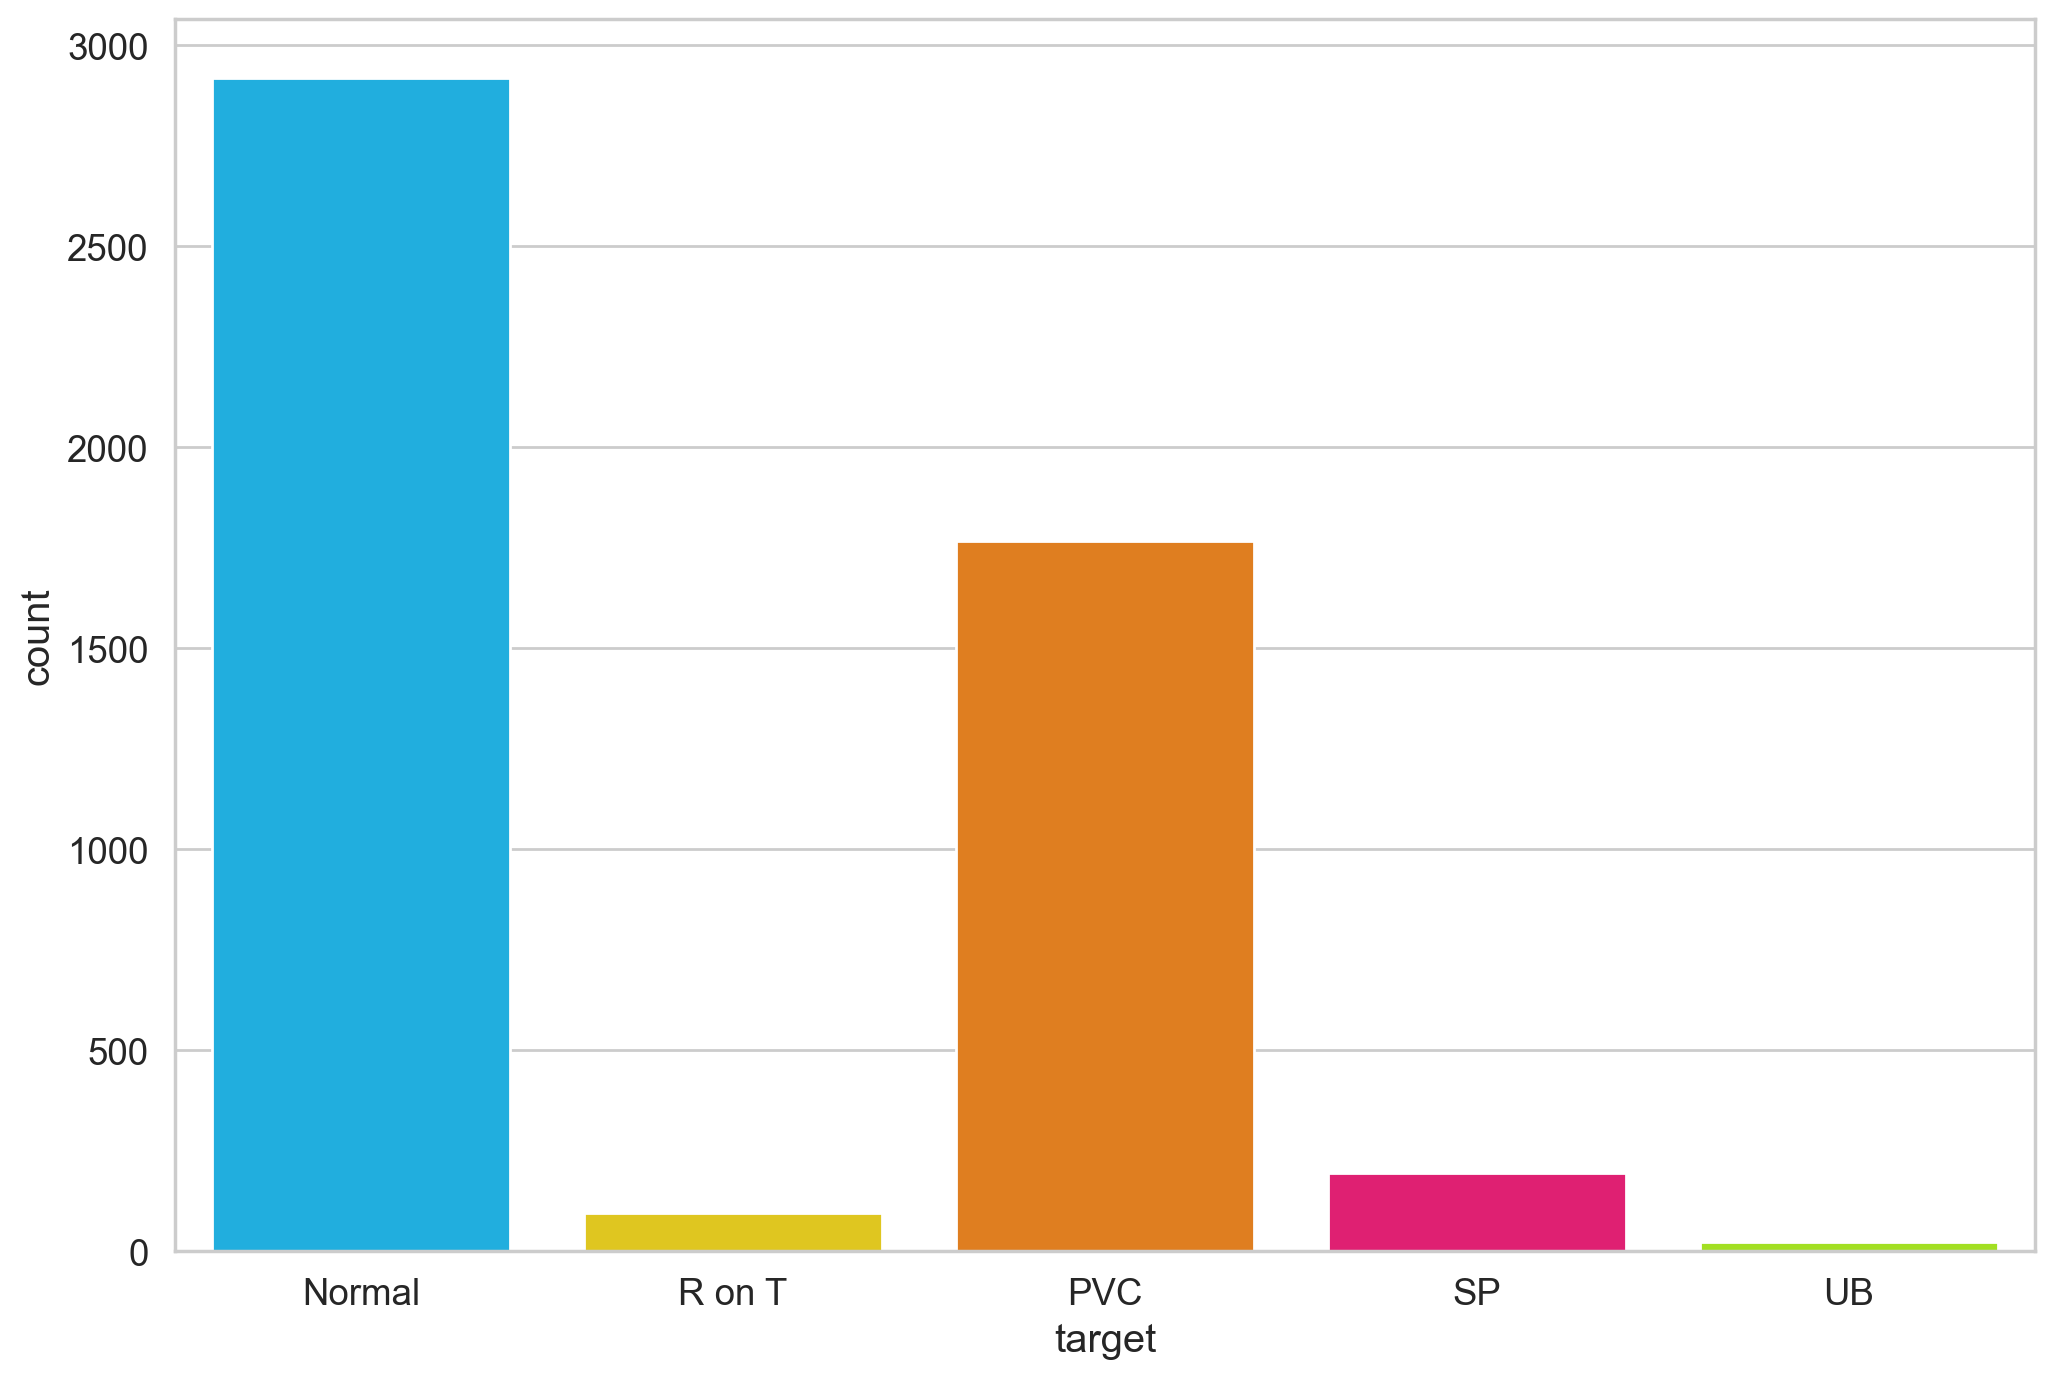

In [ ]:
ax = sns.countplot(x=df.target, data=df)
ax.set_xticklabels(class_names)

In [ ]:
# checking mean values of each class
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )                                             # standard deviation
  ax.set_title(class_name)

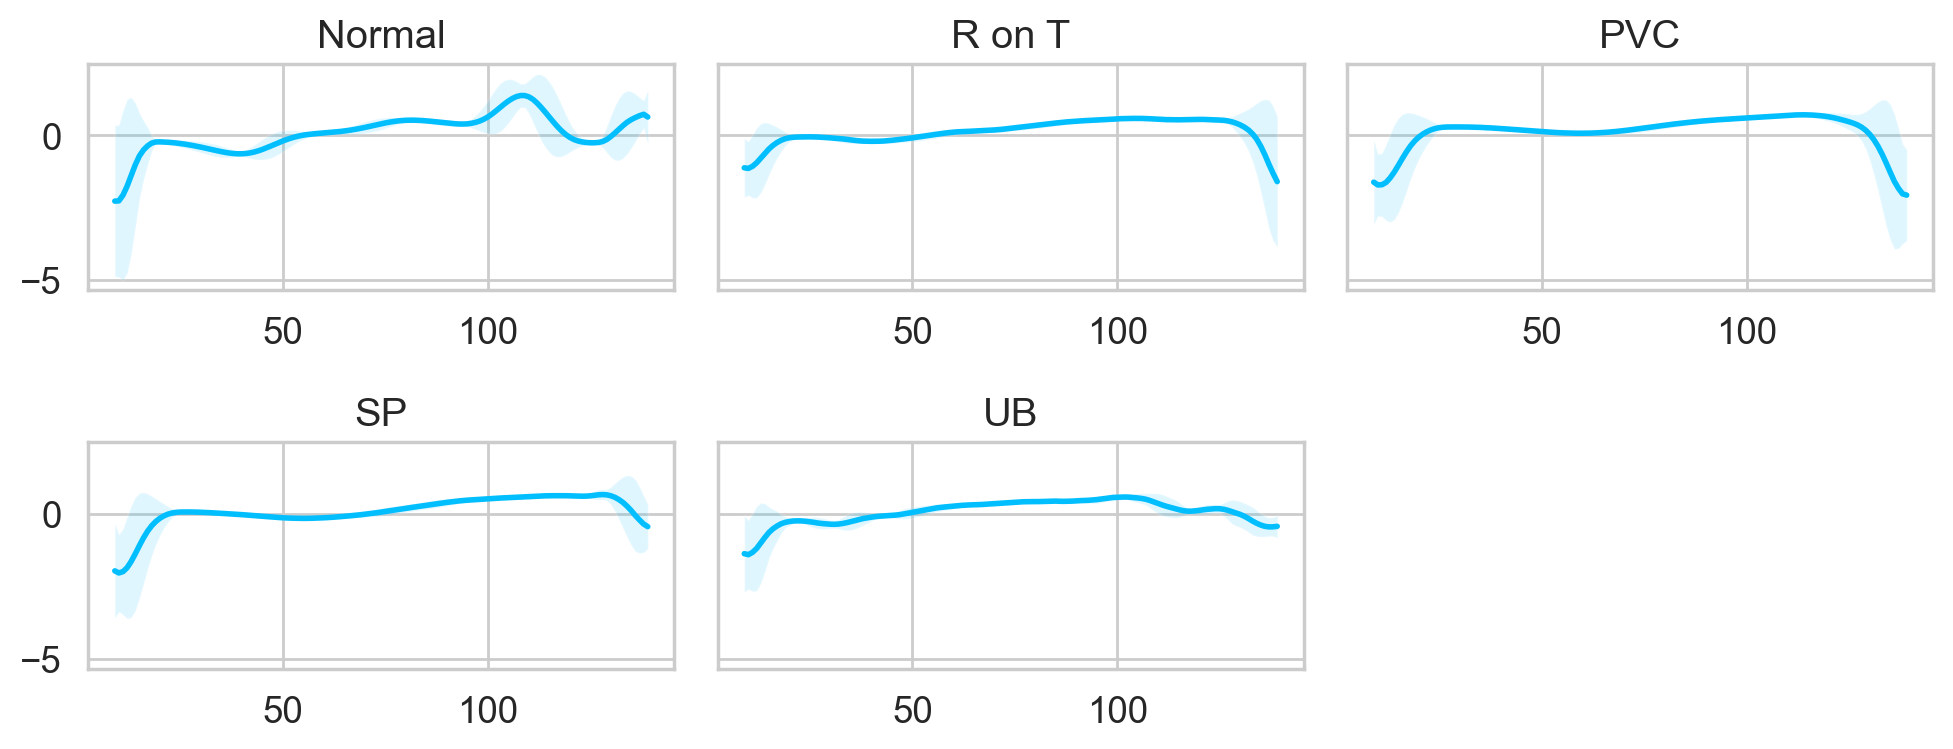

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(10, 4)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()                         # taking mean value for each column by axis = 0
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])               # deleting last axis cause we only have 5 classes
fig.tight_layout();

<a id="section-three"></a>
## Data Preprocessing

In [ ]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis = 1)
normal_df.shape

(2919, 140)

Merging all other classes and mark them as anomalies ; dropping labels:

In [ ]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [ ]:
type(anomaly_df)

pandas.core.frame.DataFrame

Splitting the normal examples into train, validation and test sets:

In [ ]:
# shuffling not needed, did already

# splitting normal dataset to train & val
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state= RANDOM_SEED)

# splitting val dataframe to val & test
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state= RANDOM_SEED)

In [ ]:
test_df.shape

(219, 140)

In [ ]:
# list of np arrays
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

In [ ]:
train_sequences

[[0.24589672684669495,
  -2.3817315101623535,
  -3.3791139125823975,
  -4.150559902191162,
  -4.362152099609375,
  -3.6047351360321045,
  -2.2038300037384033,
  -1.6929112672805786,
  -1.4115928411483765,
  -0.45316028594970703,
  -0.24718457460403442,
  -0.3059365153312683,
  -0.30416616797447205,
  -0.2842707335948944,
  -0.31556546688079834,
  -0.34547117352485657,
  -0.29497477412223816,
  -0.2648085355758667,
  -0.29031097888946533,
  -0.3422454595565796,
  -0.29521724581718445,
  -0.2957247197628021,
  -0.3098176419734955,
  -0.30440768599510193,
  -0.2946707010269165,
  -0.2853673994541168,
  -0.5313791036605835,
  -0.4383581280708313,
  -0.47724878787994385,
  -0.5194209218025208,
  -0.6586382389068604,
  -0.6188662052154541,
  -0.6942232847213745,
  -0.7170539498329163,
  -0.7002668976783752,
  -0.7206091284751892,
  -0.8025250434875488,
  -0.6749008893966675,
  -0.6799812316894531,
  -0.6568108201026917,
  -0.5826912522315979,
  -0.5012039542198181,
  -0.41481608152389526,
  

In [ ]:
# converting sequences to torch tensors
# training model single example at a time so that batch size is 1

def create_dataset(sequences):

  dataset = [torch.tensor(s).unsqueeze(1) for s in sequences] # converting each sequence to a tensor & adding a dimension

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

Creating some datasets:

In [ ]:
# creating tensors

train_dataset, seq_len, n_features = create_dataset(train_sequences)

val_dataset, seq_len, n_features = create_dataset(val_sequences)

test_dataset, seq_len, n_features = create_dataset(test_sequences)

test_anomaly_dataset, seq_len, n_features = create_dataset(anomaly_sequences)

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_sequences)
print(seq_len, n_features)

140 1


In [ ]:
print(len(train_dataset))
type(train_dataset)

2481


list

In [ ]:
test_normal_dataset, seq_len, n_features = create_dataset(test_sequences)

<a id="section-five"></a>
## Building an LSTM Autoencoder

In [ ]:
# using Recurrent Autoencoder and tweaking with a linear layer into the decoder

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))   # (batch_size, seq_len, num of features)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))  # num of units/neurons into the hidden layer

In [ ]:
# passing in results from the encoder

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    # outputting univariate time series with 140 predictions
    self.output_layer = nn.Linear(self.hidden_dim, n_features)  # dense output layer; contains 140 examples

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))    # reshaping

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)        # moving model to gpu

<a id="section-six"></a>
## Training

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)     # summing error; L1Loss = mean absolute error in torch

  history = dict(train=[], val=[])                      # recording loss history

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []

    for seq_true in train_dataset:     # iterate over each seq for train data
      optimizer.zero_grad()            # no accumulation

      seq_true = seq_true.to(device)   # putting sequence to gpu
      seq_pred = model(seq_true)       # prediction

      loss = criterion(seq_pred, seq_true)  # measuring error

      loss.backward()                  # backprop
      optimizer.step()

      train_losses.append(loss.item())  # record loss by adding to training losses

    val_losses = []
    model = model.eval()
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for seq_true in val_dataset:
          seq_true = seq_true.to(device)   # putting sequence to gpu
          seq_pred = model(seq_true)       # prediction

          loss = criterion(seq_pred, seq_true)  # recording loss

          val_losses.append(loss.item())    # storing loss into the validation losses
    train_loss = np.mean(train_losses)   # computing loss on training and val data for this epoch
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history      # after training, returning model to evaluation mode

In [ ]:
model, history = train_model(model, train_dataset, val_dataset, n_epochs= 150)

Epoch 1: train loss = 80.22195907832634, val loss = 57.64975127128706
Epoch 2: train loss = 56.185061970241414, val loss = 54.856308645309376
Epoch 3: train loss = 55.183637889629885, val loss = 54.05674330828941
Epoch 4: train loss = 52.9704988695642, val loss = 50.0316851019315
Epoch 5: train loss = 50.010172765901714, val loss = 50.15121481734324
Epoch 6: train loss = 43.349208405881775, val loss = 36.17019917649221
Epoch 7: train loss = 33.97958148193667, val loss = 35.34496180216471
Epoch 8: train loss = 29.442856759037138, val loss = 30.606700444330365
Epoch 9: train loss = 27.098237767617388, val loss = 26.16713969348228
Epoch 10: train loss = 25.200713676197402, val loss = 25.763092385035126
Epoch 11: train loss = 24.141944705743263, val loss = 24.374896467548528
Epoch 12: train loss = 31.198287526814507, val loss = 26.177592425585882
Epoch 13: train loss = 25.4836126813385, val loss = 25.16312886155359
Epoch 14: train loss = 23.95163838472255, val loss = 25.430061126952847
Epo

KeyboardInterrupt: 

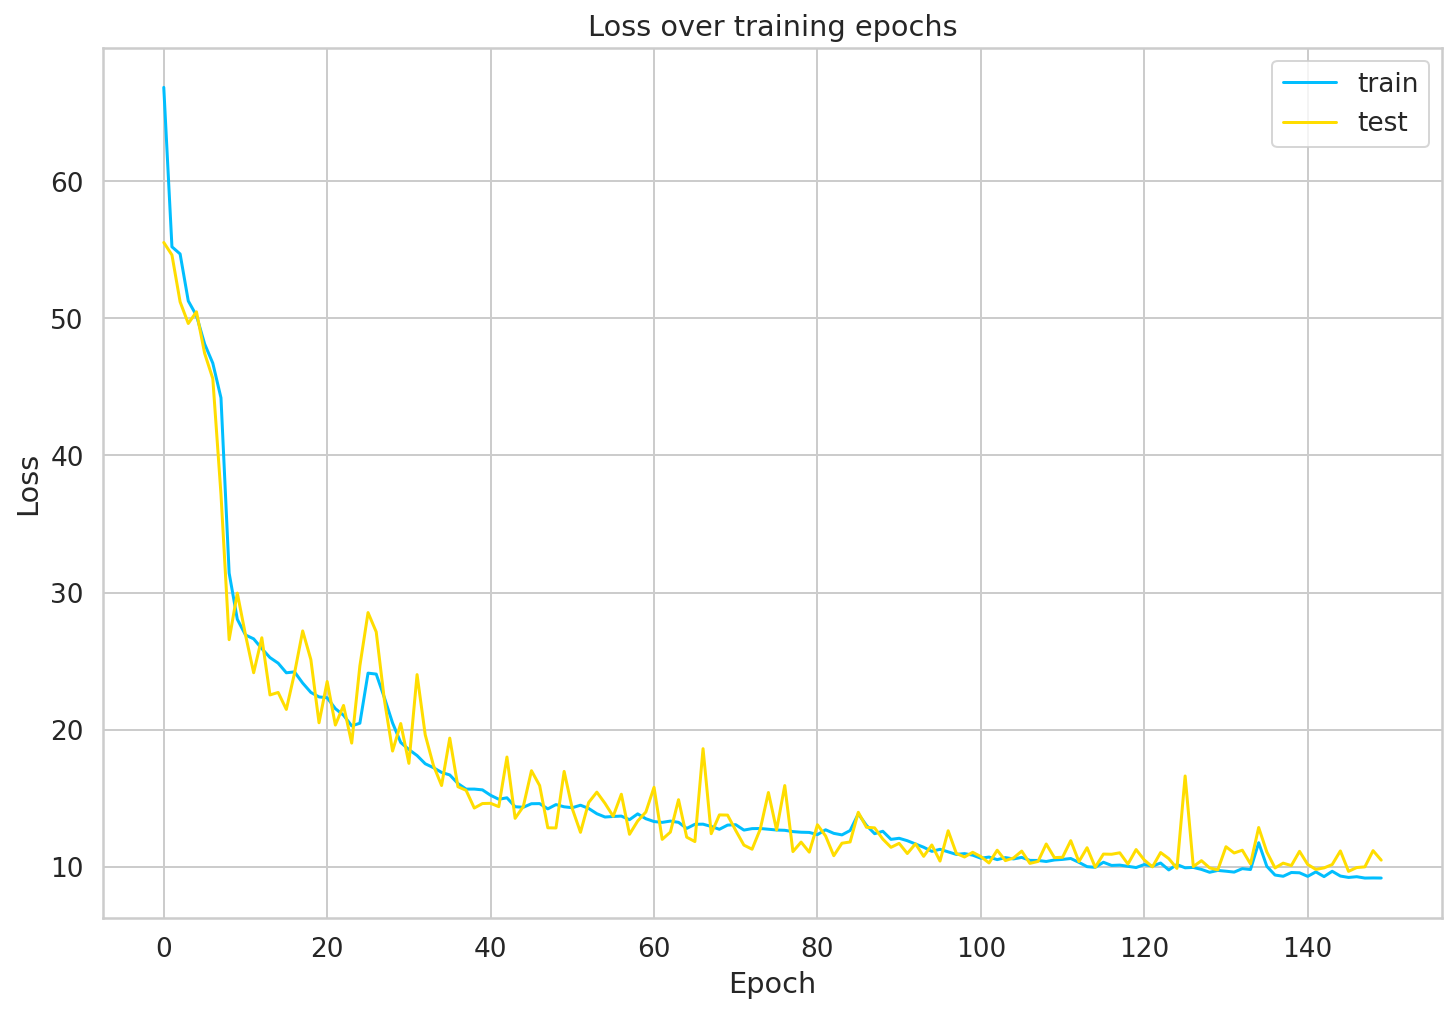

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

<a id="section-seven"></a>
## Saving the model

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [ ]:
# loading pre-trained model from checkpoint

model = torch.load('model.pth')
model = model.to(device)

<a id="section-eight"></a>
## Choosing a threshold

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction = 'sum').to(device) #L1 to gpu

  with torch.no_grad():
    model = model.eval()      # putting in evaluation mode
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)  # calculating loss

      predictions.append(seq_pred.cpu().numpy().flatten()) # appending predictions & loss to results
      losses.append(loss.item())
  return predictions, losses


The helper function goes through each example in the dataset and records the predictions and losses (reconstruction error).

In [ ]:
_, losses = predict(model, train_dataset)

C:\Users\ACER\AppData\Local\Temp\ipykernel_17736\1427981831.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins= 50, kde= True)
d:\anaconda3\envs\Torch_py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

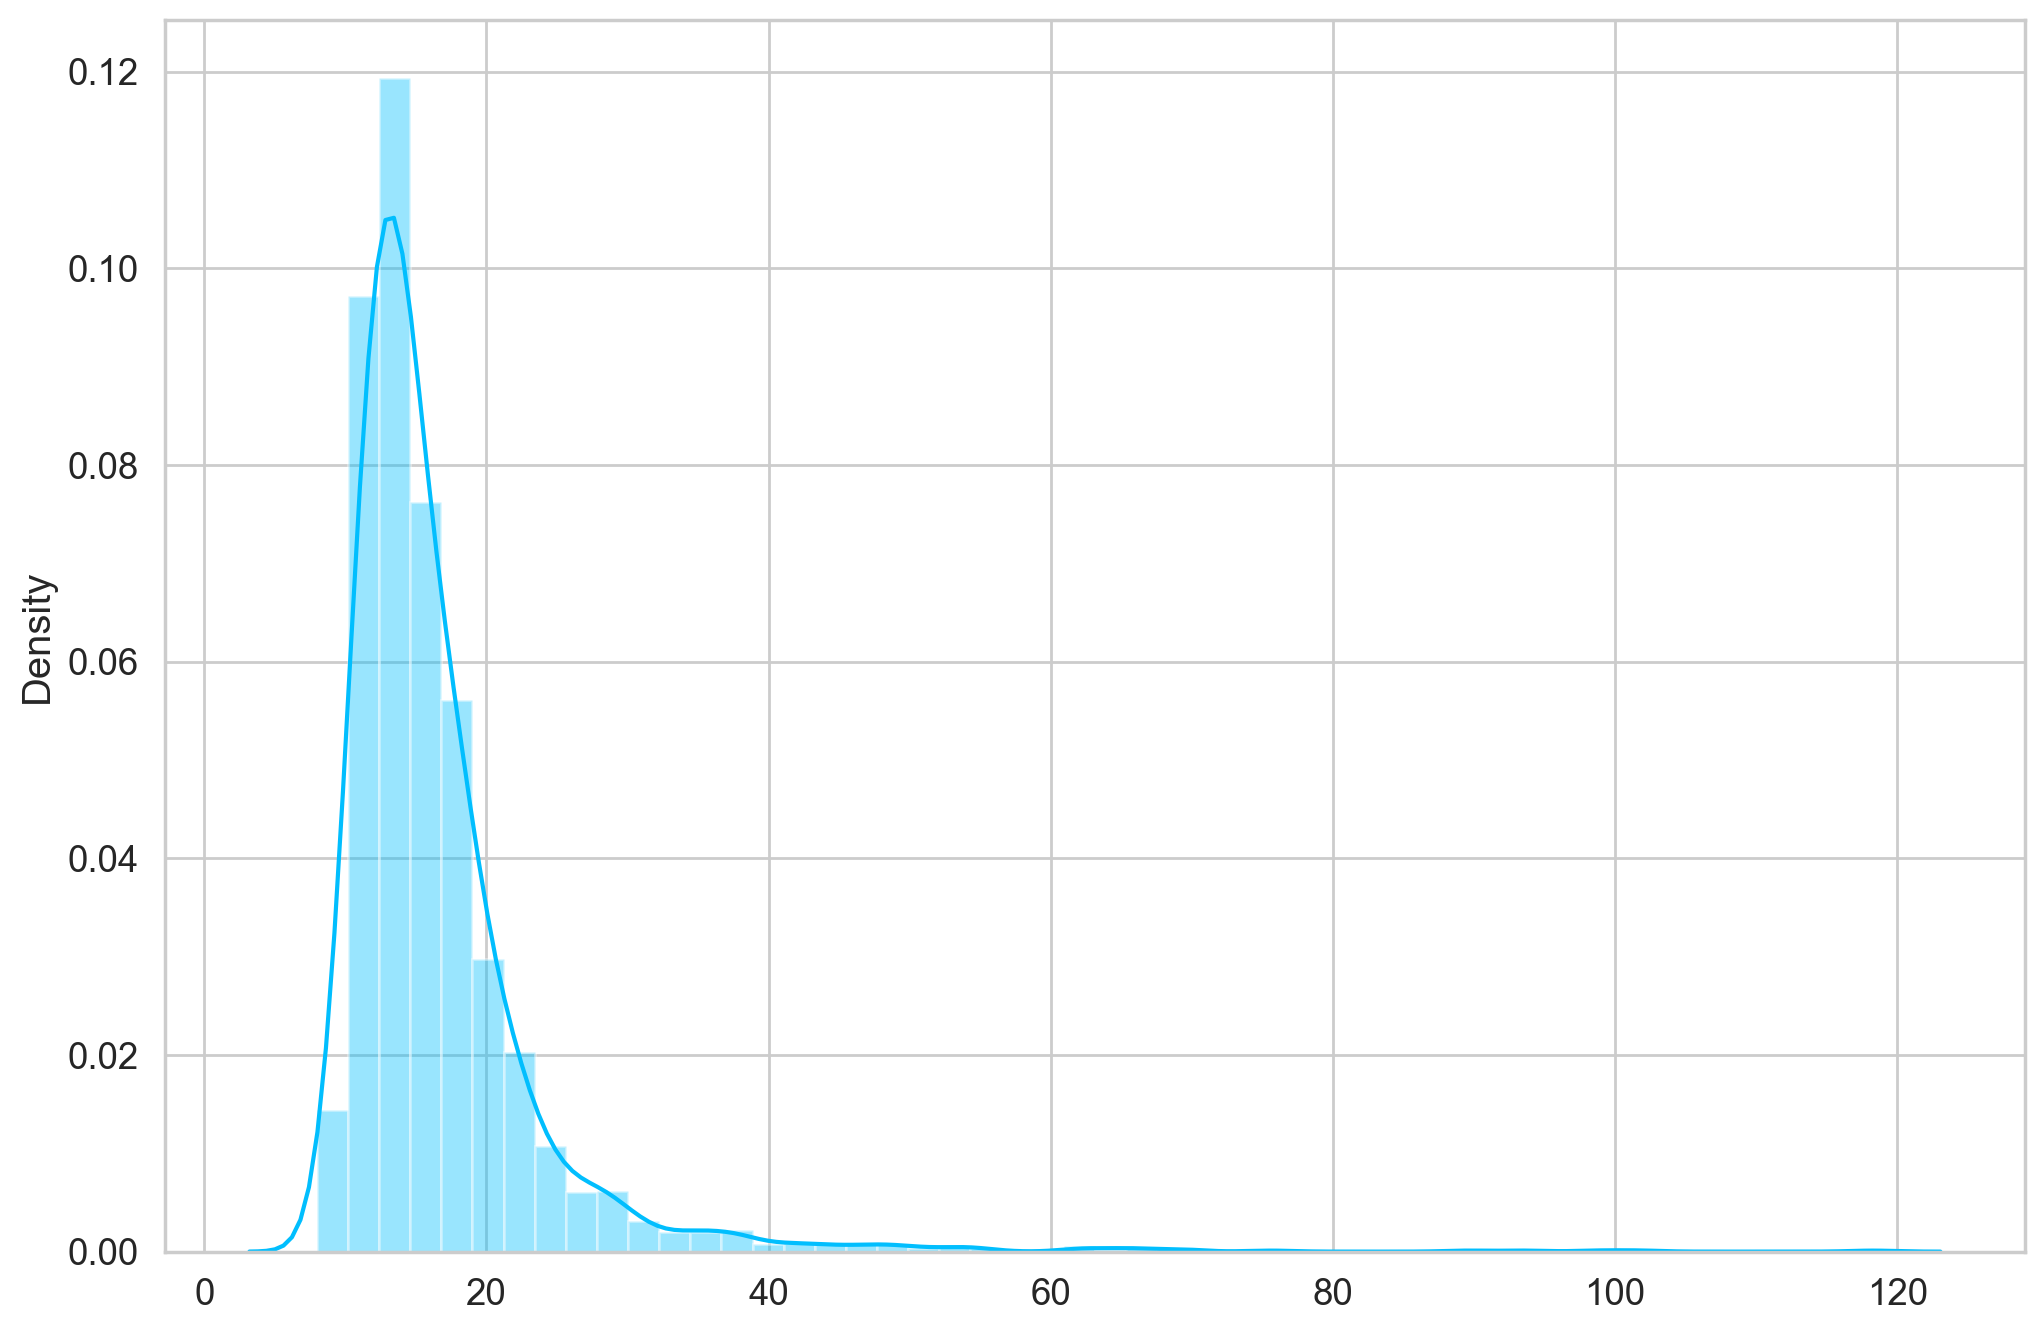

In [ ]:
# plotting the loss/ reconstruction error
sns.distplot(losses, bins= 50, kde= True)

The majority of the loss (reconstruction error) seems to be below 25. So normal heartbeat threshold can be around 25.

Identifying *false positives* is okay but not detecting an anomaly can cause fatal outcome. So threshold should be low.

In [ ]:
THRESHOLD = 26

<a id="section-nine"></a>
## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

<a id="section-ten"></a>
### Normal hearbeat Predictions

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

C:\Users\ACER\AppData\Local\Temp\ipykernel_17736\3784438109.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins= 50, kde= True);
d:\anaconda3\envs\Torch_py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


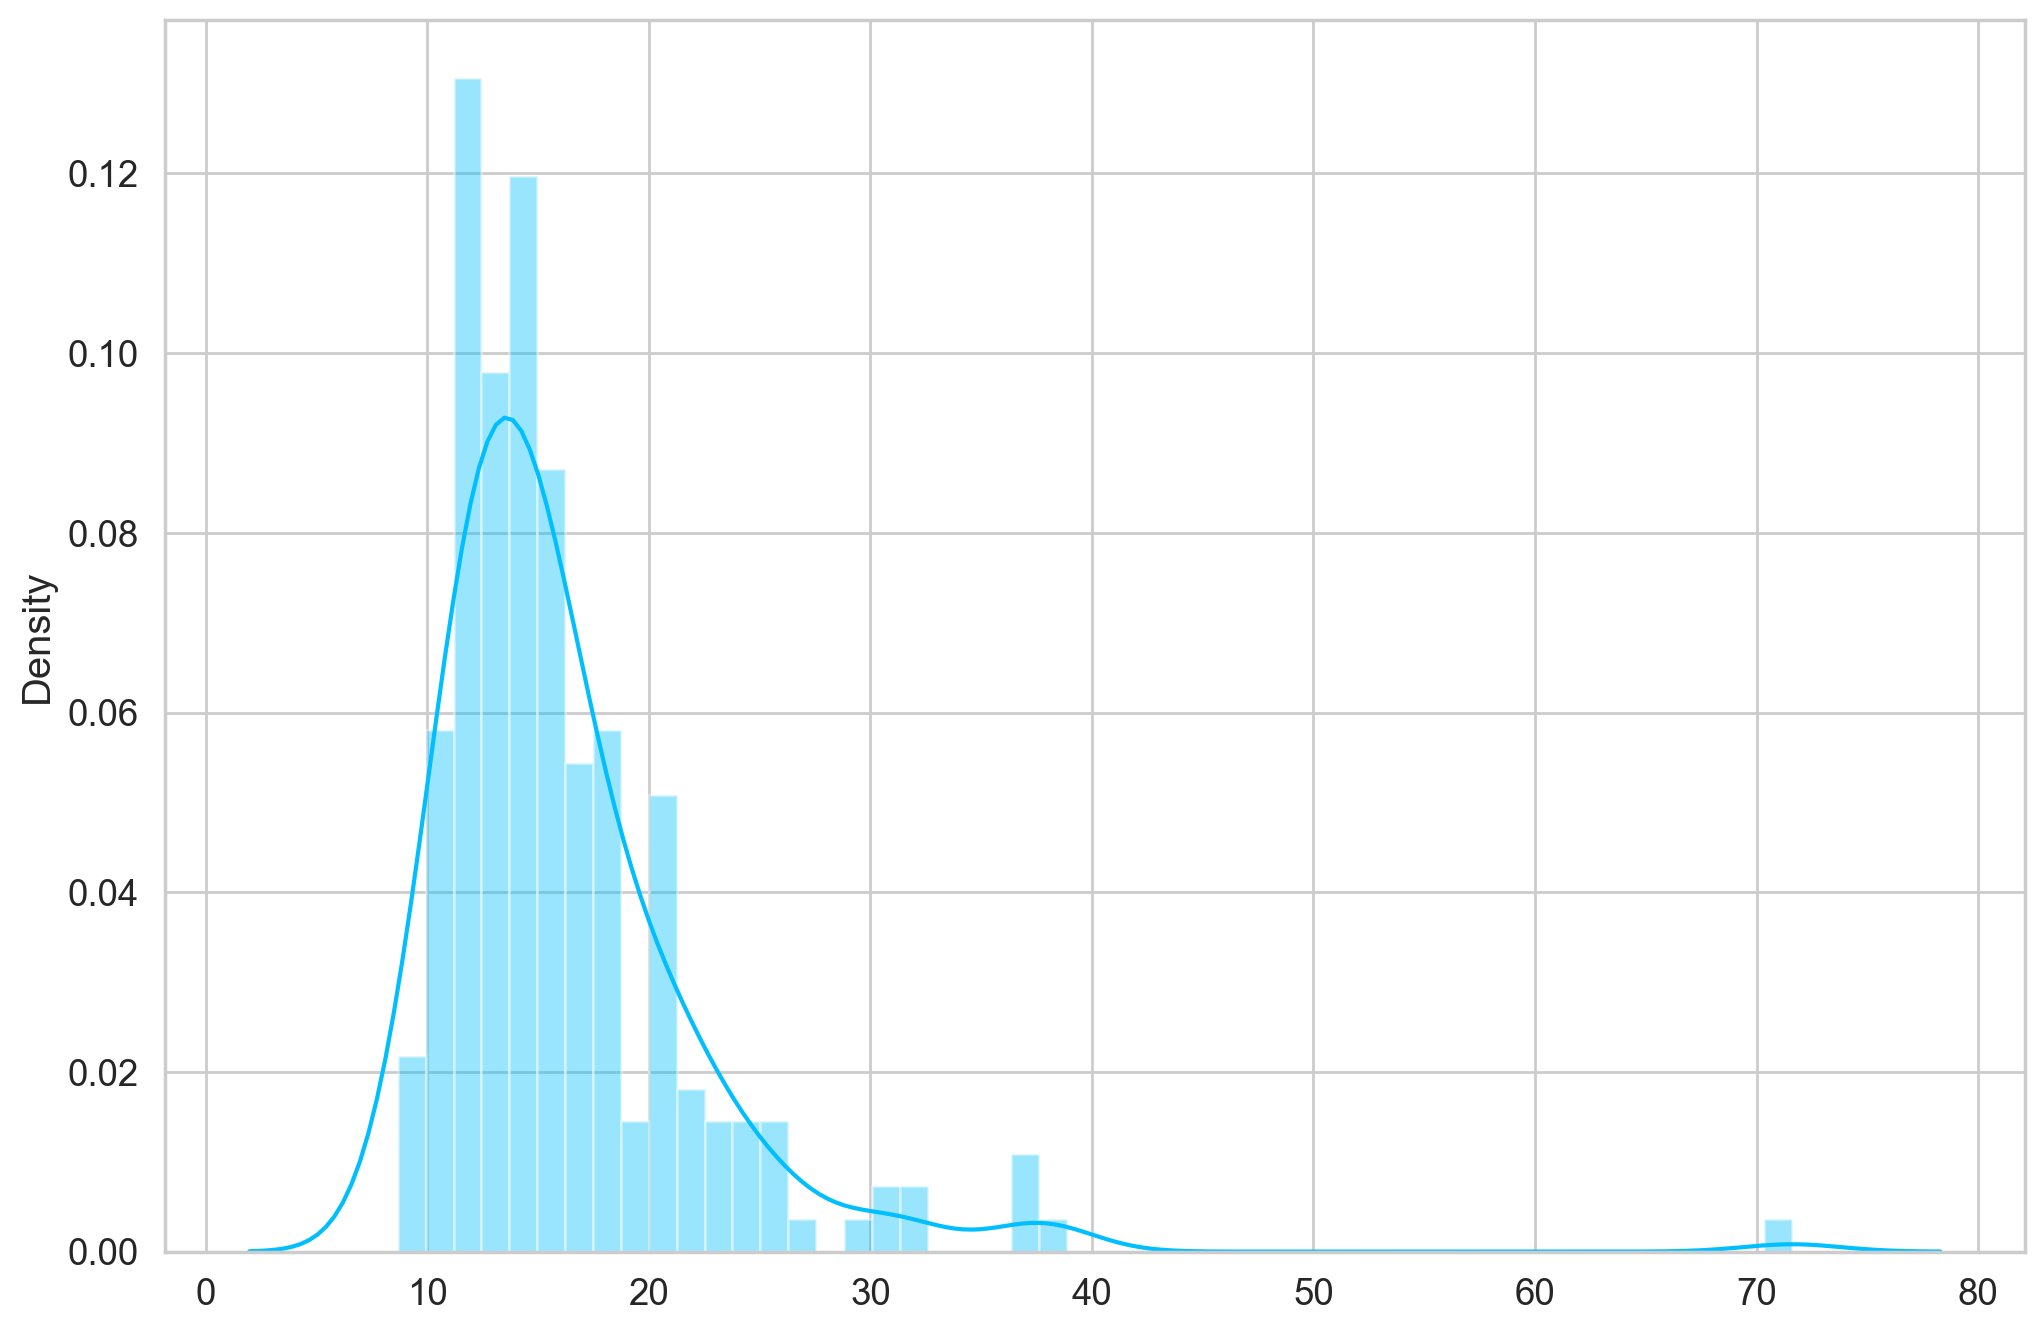

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)

sns.distplot(pred_losses, bins= 50, kde= True);

Seems like majority of the reconstruction error of heartbeat examples of the test set are below threshold 26, whereas occasionally some still have more reconstruction error.

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal precitions: {correct}/{len(test_normal_dataset)}')

Correct normal precitions: 207/219


<a id="section-eleven"></a>
### Anomaly predictions

C:\Users\ACER\AppData\Local\Temp\ipykernel_17736\811703296.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins= 50, kde= True);
d:\anaconda3\envs\Torch_py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


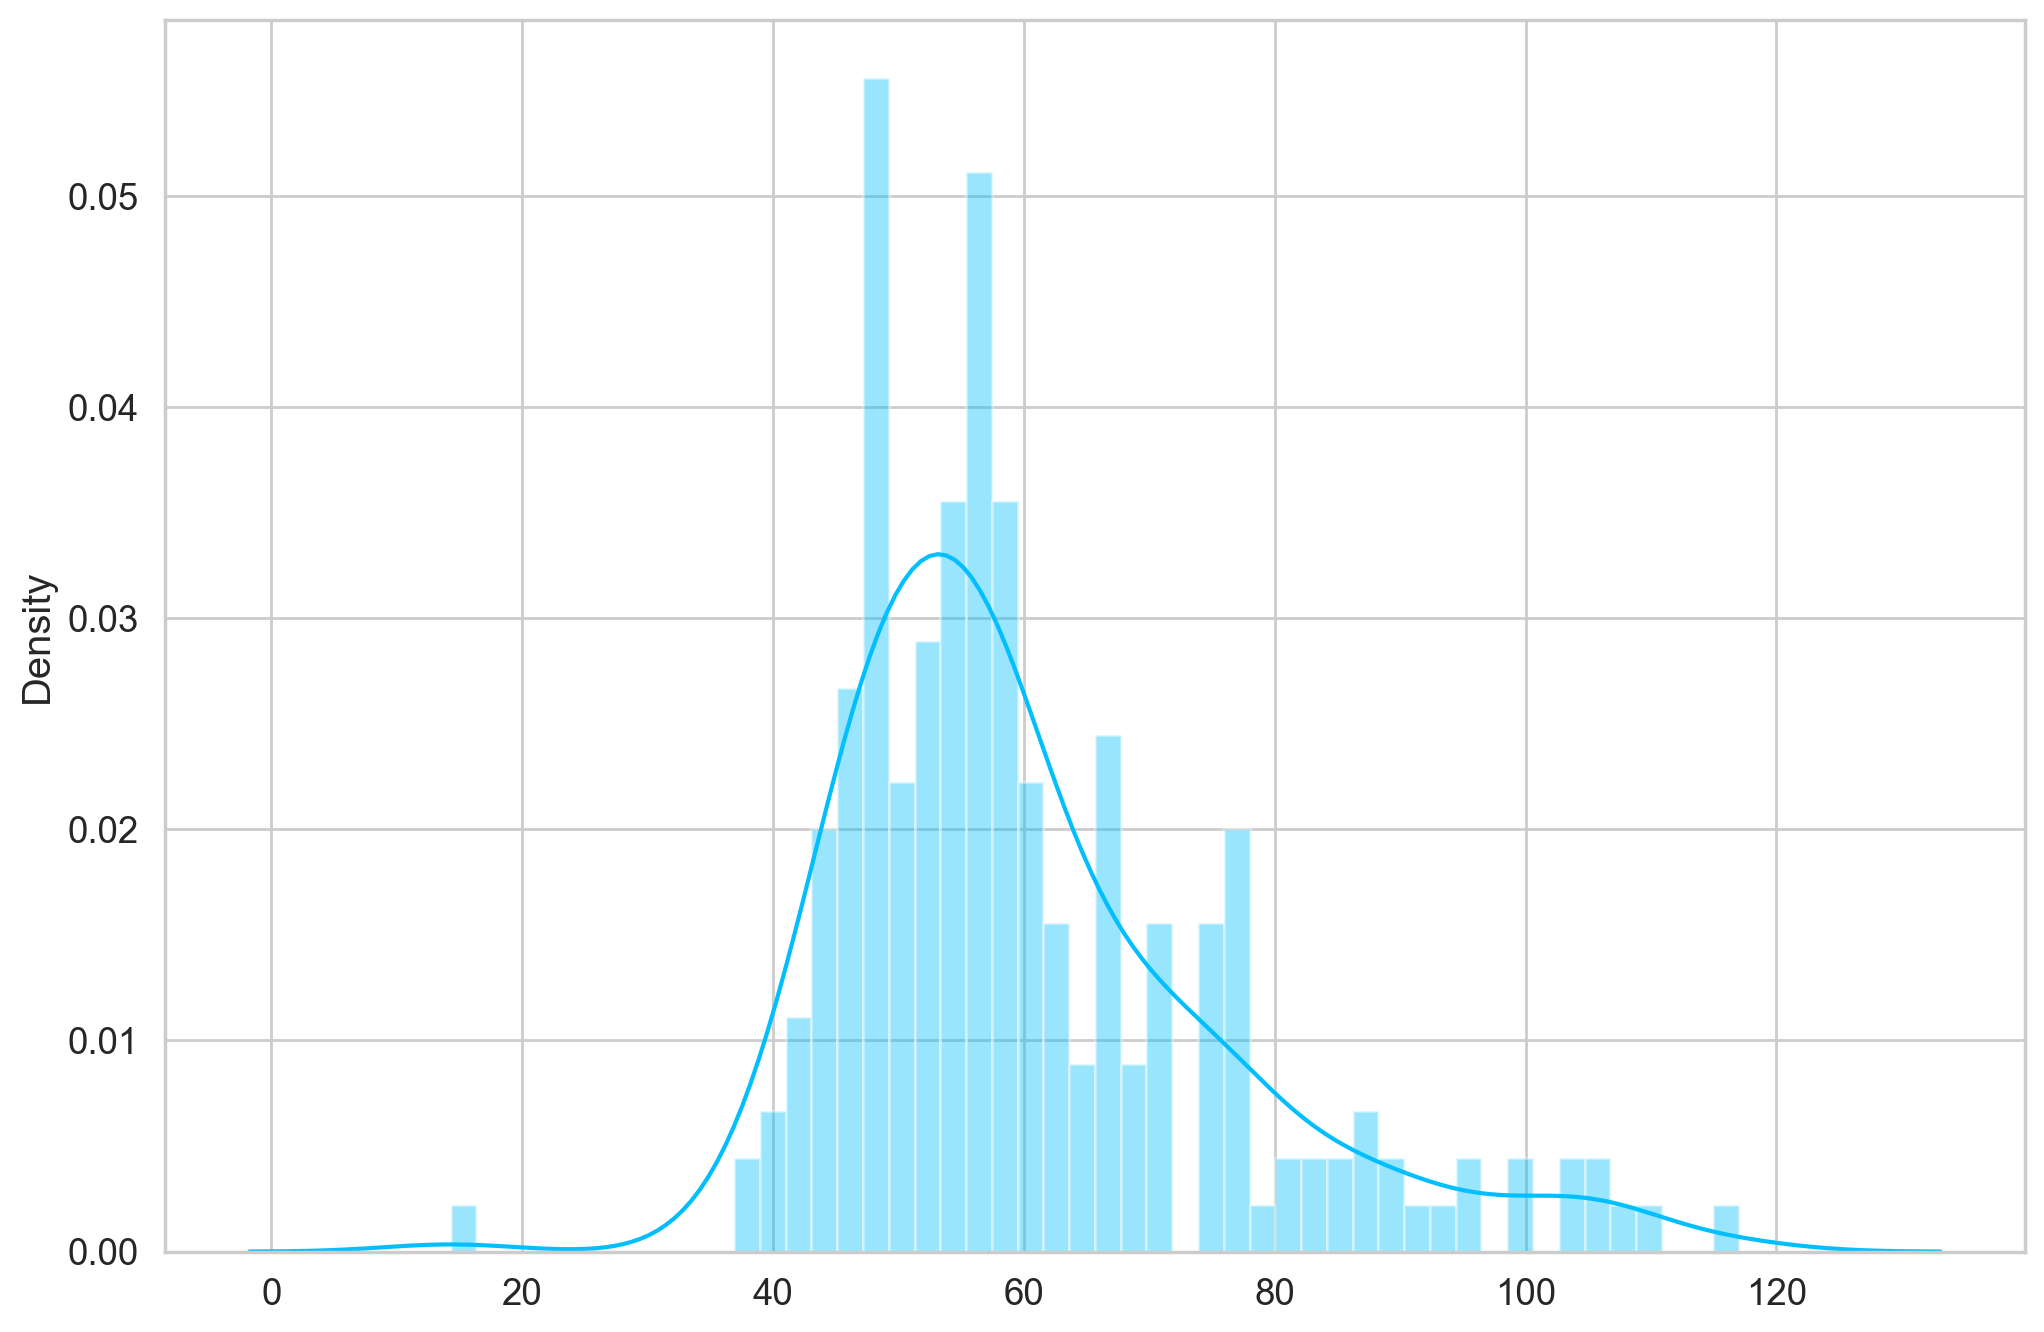

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

predictions, pred_losses = predict(model, anomaly_dataset)

sns.distplot(pred_losses, bins= 50, kde= True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly precitions: {correct}/{len(anomaly_dataset)}')

Correct anomaly precitions: 218/219


<a id="section-twelve"></a>
## Looking at Examples

In [ ]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label= 'true')
    ax.plot(predictions[0], label= 'predicted')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})') # showing loss in the title with 2 decimal points
    ax.legend()

In [ ]:
# 1st row is 6 examples from normal heartbeat, next row represents anomalies
fig, axs = plt.subplots(
    nrows= 2,
    ncols= 6,
    sharex = True,
    sharey = True,
    figsize = (16, 6)
)

# looping through 6 examples
for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title= 'Normal', ax = axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title= 'Anomaly', ax = axs[1, i])

fig.tight_layout();

<a id="section-thirteen"></a>
## Generate story

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
# Tải mô hình và bộ tokenizer của GPT-3
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

ecg_model = torch.load('model.pth')

In [ ]:
def process_data(file_path):
    # read data from txt file
    with open(file_path, 'r') as f:
        data = f.read().splitlines()

    # split data into list of strings
    data = [line.split() for line in data]

    # convert list of strings into list of integers
    data = [list(map(float, line)) for line in data]

    return data


In [ ]:
ecg_model = torch.load('model.pth')

def generate_story(ecg_data):
    # heart_patterns = ecg_model(ecg_data)
    heart_patterns, pred_losses  = predict(ecg_model, ecg_data)

    # converting heart patterns to string
    if isinstance(pred_losses, list):
        pred_losses = torch.tensor(pred_losses)

    prompt = "Details the patient's cardiovascular health based on these ECG data and advises:\n"
    if all(l <= THRESHOLD for l in pred_losses):
        prompt += "The patient's heart rate is stable and within normal limits.\n"
    elif any(l > THRESHOLD for l in pred_losses):
        prompt += "The patient has some abnormal heart rate patterns, doctors need to monitor closely.\n"

    # using GPT-3 model to generate story
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = torch.ones_like(input_ids)
    model.config.pad_token_id = model.config.eos_token_id
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=150, num_return_sequences=1, do_sample=True, top_k=20, top_p=0.95, num_beams=1, temperature=1.2, early_stopping=True)
    story = tokenizer.decode(output[0], skip_special_tokens=True)

    # Cắt câu khi đạt đến độ dài tối đa
    if len(story) > 150:
        story = story[:story.rfind('.') + 1]

    return story


In [ ]:
new = process_data('D:/Github/THT_Delta_Cognition/Data/New_p2.txt')
# new = process_data('D:/Github/THT_Delta_Cognition/Data/New_p1.txt')
# converting sequences to torch tensors
new_dataset, seq_len, n_features = create_dataset(new)
# new_dataset, seq_len, n_features = create_dataset(new)
ecg_data = new_dataset

story = generate_story(ecg_data)

print(story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


details the patient's cardiovascular health based on these ECG data and advises:
The patient has some abnormal heart rate patterns, doctors need to monitor closely.
This will include checking his pulse, respiration and heart rate before he can be taken to hospital for assessment.
The physician should have the patient's body temperature and heart rate monitored before making any changes to the ECG for further testing, and before using any medications to maintain the cardiac function he has suffered in past heart attacks, heart attack.
This information could include current medication use, medications that affect blood circulation and blood glucose levels, and how long the ECG has been in use.
There are several important information that can be made public by Drs. T.A.


In [ ]:
new = process_data('D:/Github/THT_Delta_Cognition/Data/New_p1.txt')
# converting sequences to torch tensors
new_dataset, seq_len, n_features = create_dataset(new)
# new_dataset, seq_len, n_features = create_dataset(new)
ecg_data = new_dataset

story = generate_story(ecg_data)

print(story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


details the patient's cardiovascular health based on these ECG data and advises:
The patient's heart rate is stable and within normal limits.

No cardiac events can occur during follow-up (except when the patient is discharged from a hospital or surgery). The ECG can be monitored.

The individual can be expected to respond well to care and support given to them. If, within two to three months of the initial diagnosis and treatment with ECG, the patient does not respond well, it is unlikely that they will need to go into cardiac rehabilitation.

To be considered for ECG if this is the case:

The individual's heart rate is stable and within normal limits.
